In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os
import logging
from pathlib import Path

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns

import numpyro
import numpyro.distributions as dist
from numpyro.distributions.mixtures import MixtureGeneral
from numpyro.infer import MCMC, NUTS
from numpyro.diagnostics import hpdi
from hb_mep.utils import timing, plot
from hb_mep.utils.constants import (
    INTENSITY,
    RESPONSE,
    PARTICIPANT,
    FEATURES
)

numpyro.set_platform("cpu")
numpyro.set_host_device_count(12)
numpyro.enable_x64()

PARENT_PATH = Path(os.getcwd()).parent.parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [5]:
seed = jax.random.PRNGKey(0)

samples = dist.TruncatedDistribution(
    dist.StudentT(2, 10, 1),
    low=0
).sample(seed, sample_shape=(100,))

<Axes: ylabel='Density'>

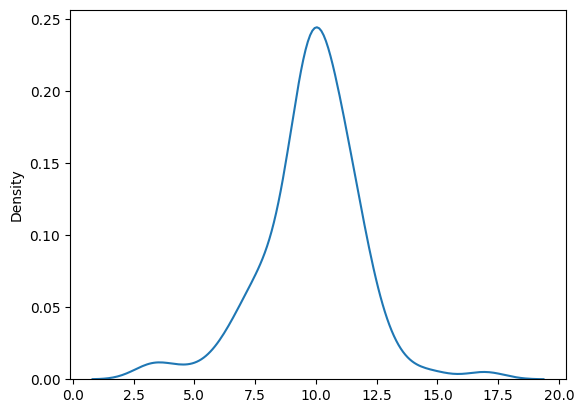

In [6]:
sns.kdeplot(samples)

Text(0.5, 1.0, 'Mixture')

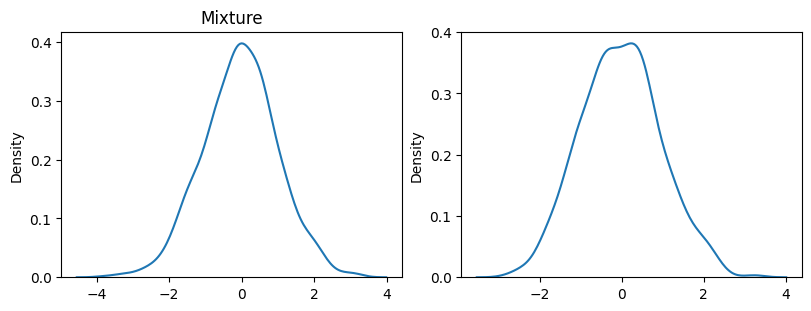

In [4]:
from random import sample
from numpyro.distributions.mixtures import MixtureGeneral



mixing_distribution = dist.Categorical(probs=jnp.array([.8, .2]))

base = dist.Normal(0, 1)
new = dist.Normal(0, 10)

component_distributions = [base, new]

Mixture = MixtureGeneral(
    mixing_distribution=mixing_distribution,
    component_distributions=component_distributions
)

seed = jax.random.PRNGKey(0)

# samples0 = Mixture.sample(seed, sample_shape=(1000,))
samples0 = dist.StudentT(20, 0, 1).sample(seed, sample_shape=(1000,))
samples1 = base.sample(seed, sample_shape=(1000,))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 3), constrained_layout=True)
sns.kdeplot(samples0, ax=ax[0])
sns.kdeplot(samples1, ax=ax[1])
ax[0].set_title("Mixture")

In [5]:
@timing
def simulate(
    random_seed: int = 0,
    n_participant: int = 10,
    n_segment: int = 1,
    n_method: int = 1,
    xMax: int = 15,
    n_points: int = 50
):
    seed = jax.random.PRNGKey(random_seed)

    a_mean = dist.TruncatedDistribution(dist.Normal(3, 5), low=0).sample(seed, sample_shape=(n_participant,))

    a_scale = dist.HalfNormal(10).sample(seed, sample_shape=(n_participant,))
    b_scale = dist.HalfNormal(20).sample(seed, sample_shape=(n_participant,))

    h_scale = dist.HalfNormal(10).sample(seed, sample_shape=(n_participant,))
    v_scale = dist.HalfNormal(50).sample(seed, sample_shape=(n_participant,))

    lo_scale = dist.HalfNormal(.2).sample(seed, sample_shape=(n_participant,))

    noise_offset_scale = dist.HalfCauchy(.05).sample(seed, sample_shape=(n_participant,))
    noise_slope_scale = dist.HalfCauchy(.05).sample(seed, sample_shape=(n_participant,))

    noise_mixture = dist.HalfCauchy(.1).sample(seed, sample_shape=(n_participant,))

    a = dist.TruncatedDistribution(dist.Normal(a_mean, a_scale), low=0).sample(seed, (n_method,)).T
    b = dist.HalfNormal(b_scale).sample(seed, (n_method,)).T

    h = dist.HalfNormal(h_scale).sample(seed, (n_method,)).T
    v = dist.HalfNormal(v_scale).sample(seed, (n_method,)).T

    lo = dist.HalfNormal(lo_scale).sample(seed, (n_method,)).T

    noise_offset = dist.HalfCauchy(noise_offset_scale).sample(seed, (n_method,)).T
    noise_slope = dist.HalfCauchy(noise_slope_scale).sample(seed, (n_method,)).T

    columns = [PARTICIPANT, FEATURES[0], FEATURES[1], INTENSITY, RESPONSE]
    x = jnp.linspace(0, xMax, n_points)
    df = None

    for i in range(n_participant):
        for j in range(n_method):
            participant = jnp.repeat(i, n_points)
            segment = jnp.repeat(0, n_points)
            method = jnp.repeat(j, n_points)

            mean = lo[i, j] + \
                jnp.maximum(
                    0,
                    -1 + \
                    (h[i, j] + 1) / \
                    jnp.power(
                        1 + \
                        (jnp.power(1 + h[i, j], v[i, j]) - 1) * \
                        jnp.exp(-b[i, j] * (x - a[i, j])),
                        1 / v[i, j]
                    )
                )

            sigma = noise_offset[i, j] + noise_slope[i, j] * mean

            """ Mixture """
            mixing_distribution = dist.Categorical(probs=jnp.array([0.95, 0.05]))

            component_distributions = [
                dist.TruncatedNormal(mean, sigma, low=0),
                dist.TruncatedNormal(0, 5, low=0)
            ]

            Mixture = MixtureGeneral(
                mixing_distribution=mixing_distribution,
                component_distributions=component_distributions
            )

            # y = dist.TruncatedNormal(mean, sigma, low=0).sample(seed)
            y = Mixture.sample(seed)

            arr = jnp.array([participant, segment, method, x, y]).T
            temp_df = pd.DataFrame(arr, columns=columns)

            if df is None:
                df = temp_df.copy()
            else:
                df = pd.concat([df, temp_df], ignore_index=True).copy()

    df[PARTICIPANT] = df[PARTICIPANT].astype(int)
    df[FEATURES[0]] = df[FEATURES[0]].astype(int)
    df[FEATURES[1]] = df[FEATURES[0]].astype(int)

    return df, a, a_mean, b, h

In [6]:
df, a, a_mean, b, h = simulate()

plot(df);

In [ ]:
seed = jax.random.PRNGKey(0)
n_participant = 10
n_method = 100000


a_mean = dist.TruncatedDistribution(dist.Normal(5, 10), low=0).sample(seed, sample_shape=(n_participant,))

a_scale = dist.HalfNormal(2).sample(seed, sample_shape=(n_participant,))

a = dist.TruncatedDistribution(dist.Normal(a_mean, a_scale), low=0).sample(seed, (n_method,)).T

In [ ]:
a_mean

Array([ 9.24504639,  1.66679324,  2.68143107,  4.63143244, 15.62832935,
        0.32234815,  2.13375801,  3.60009928,  6.0940919 , 12.55663106],      dtype=float64)

In [ ]:
a

Array([[21.73779742],
       [ 2.3033415 ],
       [ 2.86131006],
       [ 4.6212654 ],
       [76.3373841 ],
       [ 0.71981767],
       [ 2.60957954],
       [ 3.24640852],
       [ 7.31910629],
       [45.9738296 ]], dtype=float64)

<Axes: ylabel='Density'>

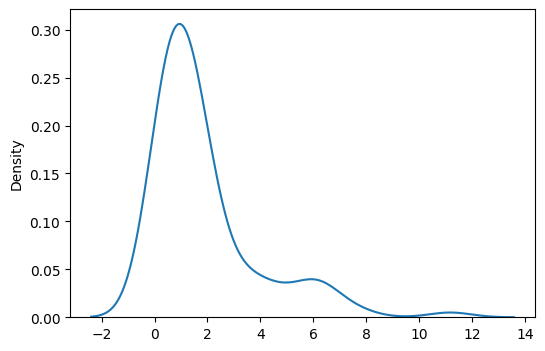

In [ ]:
a = .7

mixing_distribution = dist.Categorical(probs=jnp.array([a, 1 - a]))

component_distributions = [
    dist.TruncatedNormal(0, 1, low=0),
    dist.TruncatedNormal(0, 4, low=0)
]

Mixture = MixtureGeneral(
    mixing_distribution=mixing_distribution,
    component_distributions=component_distributions
)

rng_key = random.PRNGKey(0)

samples = Mixture.sample(rng_key, sample_shape=(100,))
# samples = dist.TruncatedNormal(0, 1, low=0).sample(rng_key, sample_shape=(100,))

plt.figure(figsize=(6, 4))
sns.kdeplot(samples)


In [ ]:
J = 8

y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])

sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

In [ ]:
def eight_schools(J, sigma, y=None):

    mu = numpyro.sample('mu', dist.Normal(0, 5))

    tau = numpyro.sample('tau', dist.HalfCauchy(5))

    with numpyro.plate('J', J):

        theta = numpyro.sample('theta', dist.Normal(mu, tau))

        numpyro.sample('obs', dist.Normal(theta, sigma), obs=y)

In [ ]:
from jax import random

from numpyro.infer import MCMC, NUTS



nuts_kernel = NUTS(eight_schools)

mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)


mcmc.run(rng_key, J, sigma, y=y, extra_fields=('potential_energy',))

2023-05-31 09:11:55,275 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
2023-05-31 09:11:55,276 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-31 09:11:55,276 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2023-05-31 09:11:55,277 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
2023-05-31 09:11:55,277 - jax._src.xla_bridge - INFO - Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.
sample: 100%|██████████| 1500/1500 [00:01<00:00, 1091.71it/s, 7 steps of size 2.51e-01. acc. prob=0